In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
from tqdm import tqdm

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
learningRate = 0.0002
batchSize = 64
imageSize = 64
ChannelsImage = 3  
NoiseDim = 100
NumEpochs = 25
featuresDisc = 64 
featuresGen = 64 
numClasses = 10
embedSize = 100

Device: cuda


In [3]:
#loading the dataset
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


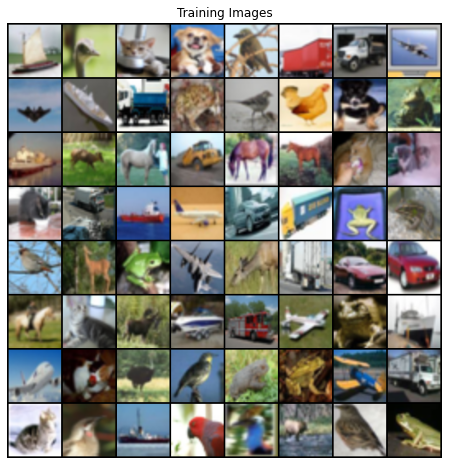

In [4]:
# Plot training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:batchSize], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
class Generator(nn.Module):
    def __init__(self, num_classes, img_size,embed_size,channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
           
            nn.ConvTranspose2d(NoiseDim+embed_size,features_g* 16, 4, 1, 0, bias = False),   

            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

gen = Generator(numClasses, imageSize,embedSize,NoiseDim, ChannelsImage, featuresGen).to(device)
initialize_weights(gen)


In [7]:
class Discriminator(nn.Module):

    def __init__(self, num_classes, img_size,channels_img, features_d):    
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            
            self.Dnet(features_d, features_d * 2, 4, 2, 1),      
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  

        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512,1,4,1,0,bias = False),
                               nn.Sigmoid())
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
                                        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
        

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            
            nn.LeakyReLU(0.2),
        )
    


    def forward(self, x):
        x = self.disc(x)
        valid = self.validity_layer(x).view(-1)
        label = self.labels(x).view(-1,11)
        return valid,label

disc = Discriminator(numClasses, imageSize,ChannelsImage, featuresDisc).to(device)
initialize_weights(disc)

In [8]:
gen.train() , disc.train()

(Generator(
   (net): Sequential(
     (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (5): Tanh()
   )
   (embed): Embedding(10, 100)
 ),
 Discriminato

In [9]:
#FID implemention#
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""
    
    DEFAULT_BLOCK_INDEX = 3

    
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
    """get fretched distance"""
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value


/home/devaguptam.s/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devaguptam.s/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
fixed_noise = torch.randn(32, NoiseDim, 1, 1).to(device)
step = 0

discOptim = optim.Adam(disc.parameters(),learningRate, betas = (0.5,0.999))
genOptim = optim.Adam(gen.parameters(), learningRate, betas = (0.5,0.999))
criterion = nn.BCELoss()

In [11]:
#training block
GenLoss = []
DiscLoss = []
img_list = []
iters = 0
FID_list = []

print("!!Training Started!!")

time_start = time.time() 
for epoch in range(NumEpochs):
    epoch = epoch+1
    


    for batch_idx, (realImg,labels) in tqdm(enumerate(dataloader)):
     
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.shape[0]
        
        fakeClassLabel =  10*torch.ones((miniBatch,),dtype = torch.long).to(device)        
        disc.zero_grad()

        r_label =  torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
        disc_real, disc_label = disc(real)
        loss_disc_realVal = criterion(disc_real, r_label)
        discRealLabelLoss = F.nll_loss(disc_label, labels) 
        realLoss_disc = loss_disc_realVal + discRealLabelLoss
        realLoss_disc.backward()

        sampleLabel = torch.randint(0, 10, (miniBatch,), dtype = torch.long).to(device)
        noise = torch.randn(miniBatch, NoiseDim, 1, 1).to(device)
        fake = gen(noise,sampleLabel) 
        disc_fake, disc_fLabel = disc(fake.detach())
        r_label.fill_(0.0)
        loss_disc_fakelVal = criterion(disc_fake, r_label)
        discFakeLabelLoss = F.nll_loss(disc_fLabel, fakeClassLabel) 
        fakeLoss_disc = loss_disc_fakelVal + discFakeLabelLoss
        fakeLoss_disc.backward()
    
        loss_disc = (realLoss_disc+fakeLoss_disc)/2
        discOptim.step()

        gen.zero_grad()
        noise = torch.randn(miniBatch, NoiseDim, 1, 1).to(device)
        sampleLabel = torch.randint(0,10,(miniBatch,),dtype = torch.long).to(device)
        r_label.fill_(1.0)
        fake = gen(noise, sampleLabel)
        genOutput, genOutputLabel = disc(fake)

        loss_gen_r = criterion(genOutput, r_label)
        genLabelLoss = F.nll_loss(genOutputLabel, sampleLabel)
        loss_gen = loss_gen_r + genLabelLoss
        loss_gen.backward()
        genOptim.step()
        

        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        
    with torch.no_grad():
        fake = gen(noise,sampleLabel).detach().cpu()
    img_list.append(utils.make_grid(fake, padding=2, normalize=True))
    
   
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)

    print(f"Epoch [{epoch}/{NumEpochs}]  \
      Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ")         
    
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))

!!Training Started!!


782it [01:35,  8.17it/s]


Epoch [1/25]        Loss Discriminator: 2.119, loss Generator: 3.165, FID Score: 432.490 


782it [01:31,  8.56it/s]


Epoch [2/25]        Loss Discriminator: 2.036, loss Generator: 2.342, FID Score: 384.047 


782it [01:24,  9.29it/s]


Epoch [3/25]        Loss Discriminator: 2.003, loss Generator: 2.562, FID Score: 360.124 


782it [01:31,  8.51it/s]


Epoch [4/25]        Loss Discriminator: 1.787, loss Generator: 2.922, FID Score: 326.645 


782it [01:24,  9.21it/s]


Epoch [5/25]        Loss Discriminator: 1.924, loss Generator: 3.124, FID Score: 330.072 


782it [01:33,  8.40it/s]


Epoch [6/25]        Loss Discriminator: 1.975, loss Generator: 4.025, FID Score: 337.275 


782it [01:28,  8.79it/s]


Epoch [7/25]        Loss Discriminator: 1.262, loss Generator: 5.729, FID Score: 338.259 


782it [01:23,  9.38it/s]


Epoch [8/25]        Loss Discriminator: 1.123, loss Generator: 4.599, FID Score: 307.575 


782it [01:32,  8.50it/s]


Epoch [9/25]        Loss Discriminator: 1.028, loss Generator: 6.847, FID Score: 329.195 


782it [00:55, 14.10it/s]


Epoch [10/25]        Loss Discriminator: 1.213, loss Generator: 8.733, FID Score: 345.253 


782it [00:42, 18.21it/s]


Epoch [11/25]        Loss Discriminator: 1.479, loss Generator: 5.220, FID Score: 343.159 


782it [00:43, 18.13it/s]


Epoch [12/25]        Loss Discriminator: 1.240, loss Generator: 3.084, FID Score: 343.736 


782it [00:42, 18.19it/s]


Epoch [13/25]        Loss Discriminator: 0.867, loss Generator: 5.649, FID Score: 312.066 


782it [00:42, 18.19it/s]


Epoch [14/25]        Loss Discriminator: 0.981, loss Generator: 6.615, FID Score: 293.196 


782it [00:43, 18.17it/s]


Epoch [15/25]        Loss Discriminator: 1.178, loss Generator: 6.432, FID Score: 325.860 


782it [00:43, 18.08it/s]


Epoch [16/25]        Loss Discriminator: 1.249, loss Generator: 3.271, FID Score: 297.393 


782it [00:43, 18.16it/s]


Epoch [17/25]        Loss Discriminator: 0.812, loss Generator: 9.715, FID Score: 264.760 


782it [00:43, 18.17it/s]


Epoch [18/25]        Loss Discriminator: 0.916, loss Generator: 8.126, FID Score: 316.681 


782it [00:43, 17.88it/s]


Epoch [19/25]        Loss Discriminator: 1.240, loss Generator: 7.733, FID Score: 293.511 


782it [00:43, 18.16it/s]


Epoch [20/25]        Loss Discriminator: 0.818, loss Generator: 8.179, FID Score: 301.757 


782it [00:43, 18.04it/s]


Epoch [21/25]        Loss Discriminator: 0.723, loss Generator: 8.105, FID Score: 319.984 


782it [00:42, 18.24it/s]


Epoch [22/25]        Loss Discriminator: 0.760, loss Generator: 14.095, FID Score: 321.907 


782it [00:43, 17.86it/s]


Epoch [23/25]        Loss Discriminator: 0.643, loss Generator: 6.382, FID Score: 309.477 


782it [00:42, 18.20it/s]


Epoch [24/25]        Loss Discriminator: 0.894, loss Generator: 11.125, FID Score: 335.747 


782it [00:42, 18.28it/s]


Epoch [25/25]        Loss Discriminator: 0.737, loss Generator: 7.627, FID Score: 354.959 


 elapsed time：1718.66 s.


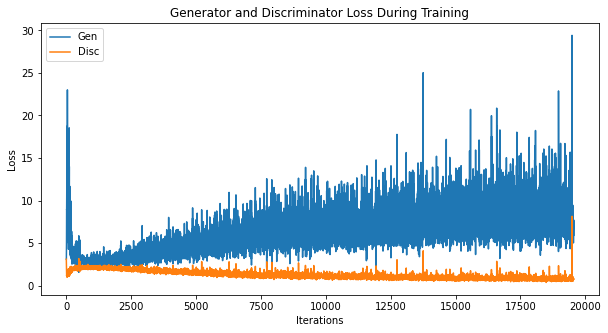

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

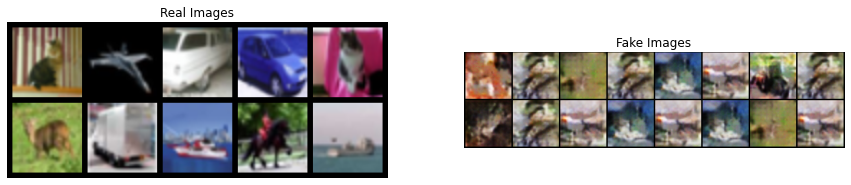

In [13]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

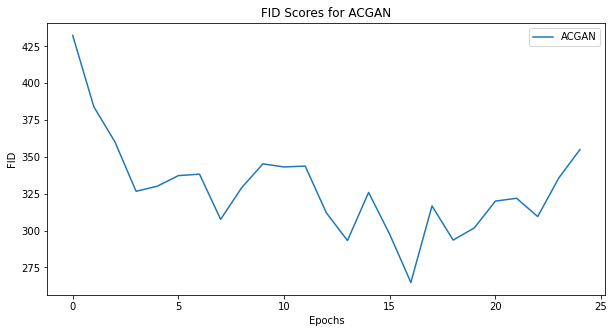

In [16]:
plt.figure(figsize=(10,5))
plt.title("FID Scores for ACGAN")
plt.plot(FID_list,label="ACGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.show()

In [15]:
 np.mean(FID_list), FID_list[-5]

(329.0051529200728, 319.98355991482526)